In [1]:
!pip install monai[all] pydicom nibabel matplotlib


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/37.4 MB ? eta -:--:--
   -- ------------------------------------- 2.1/37.4 MB 10.7 MB/s eta 0:00:04
   ---- ----------------------------------- 4.2/37.4 MB 10.5 MB/s eta 0:00:04
   ------ --------------------------------- 6.3/37.4 MB 10.7 MB/s eta 0:00:03
   --------- ------------------------------ 9.2/37.4 MB 10.8 MB/s eta 0:00:03
   ------------ --------------------------- 11.5/37.4 MB 11.3 MB/s eta 0:00:03
   -------------- ------------------------- 13.6/37.4 MB 11.3 MB/s eta 0:00:03
   ----------------- ---------------------- 16.0/37.4 MB 10.8 MB/s eta 0:00:02
   ------------------- -------------------- 17.8/37.4 MB 11.1 MB/s eta 0:00:02
   -------------------- ------------------- 18.9/37.4 M

In [2]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import torch

from monai.networks.nets import UNet
from monai.transforms import Resize


In [4]:
# Path to folder containing .dcm files
dicom_folder =  r"C:\Users\anude\OneDrive\Desktop\project\ProstateX-0000\07-07-2011-NA-MR prostaat kanker detectie WDSmc MCAPRODETW-05711\3.000000-t2tsesag-87368"
# Load and sort DICOM slices
slices = [pydicom.dcmread(os.path.join(dicom_folder, f)) for f in os.listdir(dicom_folder) if f.endswith(".dcm")]
slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Stack into 3D volume
volume = np.stack([s.pixel_array for s in slices]).astype(np.float32)

# Normalize
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
volume = np.expand_dims(volume, axis=0)  # Add channel


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,  # Assuming binary segmentation (e.g., background vs prostate)
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

model.eval()


TypeError: UNet.__init__() got an unexpected keyword argument 'dimensions'

In [11]:
!pip install --upgrade "monai[all]"


In [8]:
from monai.networks.nets.basic_unet import BasicUNet

model = BasicUNet(
    spatial_dims=3,  # 3D U-Net
    in_channels=1,
    out_channels=2
).to(device)


BasicUNet features: (32, 32, 64, 128, 256, 32).


In [12]:
from monai.transforms import Resize

# Resize the [C, H, W, D] volume before adding batch
resizer = Resize(spatial_size=(128, 128, 64))
resized_volume = resizer(volume)  # still shape [1, H, W, D]

# Now add batch dim and convert to tensor
input_tensor = torch.tensor(resized_volume).unsqueeze(0).to(device)  # [1, 1, H, W, D]


with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.argmax(output, dim=1).cpu().numpy()[0]


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


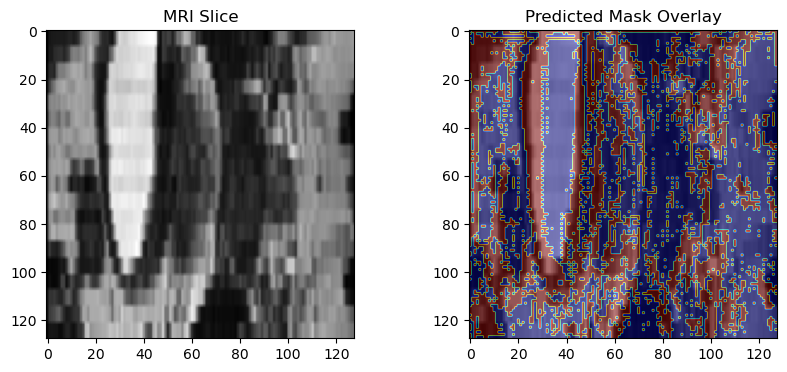

In [14]:
def show_prediction(img_tensor, pred_mask, slice_idx=32):
    img_slice = img_tensor[0, 0, :, :, slice_idx].cpu().numpy()
    mask_slice = pred_mask[:, :, slice_idx]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_slice, cmap="gray")
    plt.title("MRI Slice")

    plt.subplot(1, 2, 2)
    plt.imshow(img_slice, cmap="gray")
    plt.imshow(mask_slice, cmap="jet", alpha=0.5)
    plt.title("Predicted Mask Overlay")
    plt.show()

show_prediction(input_tensor, prediction)
